# LSTM model - one hour step
### Predictions  for different data sizes
### Data from years: [2012-2020]; [2015-2020]; [2018-2020]

Libraries import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error

Libraries from my python script

In [2]:
from different_functions import transform_and_split_data, LSTM_model, transform_and_split_data, make_predictions

#### CSV file reading and data preparation

In [3]:
# Read the CSV file
all_data = pd.read_csv("data_for_main_model/data_ready_for_training.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)
all_data = all_data[["relh", "skph", "temp", "minutes", "year"]]

In [4]:
all_data.tail()

,relh,skph,temp,minutes,year
144145,42.73,22.224,9.0,30,2020
144146,42.44,22.224,8.0,0,2020
144147,45.73,16.668,8.0,30,2020
144148,48.96,14.816,7.0,0,2020
144149,48.67,1.852,6.0,30,2020


In [5]:
# only full hours
all_data = all_data[all_data['minutes'] == 0]
all_data.drop('minutes',axis='columns', inplace=True)

MSE calculations for given window size and etc. for the next 1 to 3 hours

In [6]:
def return_time(data,window_size,test_size,valid_size,epochs,learning_rate, save_model = False):
    
    MSE_humid = []
    MAE_humid = []

    MSE_wind = []
    MAE_wind = []
    
    MSE_temp = []
    MAE_temp = []

    # MSE calculations for given window size and etc. in next 1 to 3 next hours
    # last_pred_hour == 3 means that predictions are from +1 hour till +3 hours
    last_pred_hour = 3
    for hour in range(last_pred_hour):
        # (hour == ) it means that predictions will be made for next one hour
        X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std = transform_and_split_data(data.copy(), window_size, test_size, valid_size, hour)  
        X_test.size
        model = LSTM_model(X_train, y_train, X_val, y_val, epochs, learning_rate, window_size)

        ## save as binary file .pkl
        if(save_model):
            file_name = "lstm_" + str(hour+1) + ".pkl"
            with open(file_name, "xb") as f_1:
                pickle.dump(model, f_1, -1)

        pred, actaul = make_predictions(model, X_test, y_test,  training_mean, training_std)
        MSE_humid.append(mean_squared_error(actaul[0], pred[0]))
        MAE_humid.append(mean_absolute_error(actaul[0], pred[0]))
        MSE_wind.append(mean_squared_error(actaul[1], pred[1]))
        MAE_wind.append(mean_absolute_error(actaul[1], pred[1]))
        MSE_temp.append(mean_squared_error(actaul[2], pred[2]))
        MAE_temp.append(mean_absolute_error(actaul[2], pred[2]))


    return MSE_humid, MAE_humid, MSE_wind, MAE_wind, MSE_temp, MAE_temp, pred, actaul

In [7]:
test_size = 0.15
valid_size = 0.15
epochs = 12
learning_rate=0.001

AllMAE_temp_6 = []
AllMAE_humid_6 = []
AllMAE_wind_6 = []

AllMAE_temp_12 = []
AllMAE_humid_12 = []
AllMAE_wind_12 = []

# for [12-20]; [15-20]; [18-20]
for year in range(2012,2019,3):
    
    # when window of data input == last 6 hours
    window_size = 6
    MSE_humid_6, MAE_humid_6, MSE_wind_6, MAE_wind_6, MSE_temp_6, MAE_temp_6, pred_6, actaul_6  = return_time(all_data[["relh", "skph", "temp"]], window_size,test_size,valid_size,epochs,learning_rate)

    AllMAE_temp_6.append(MAE_temp_6)
    AllMAE_humid_6.append(MAE_humid_6)
    AllMAE_wind_6.append(MAE_wind_6)

    # when window of data input == last 12 hours
    window_size = 12
    MSE_humid_12, MAE_humid_12, MSE_wind_12, MAE_wind_12, MSE_temp_12, MAE_temp_12, pred_12, actaul_12  = return_time(all_data[["relh", "skph", "temp"]], window_size,test_size,valid_size,epochs,learning_rate)

    AllMAE_temp_12.append(MAE_temp_12)
    AllMAE_humid_12.append(MAE_humid_12)
    AllMAE_wind_12.append(MAE_wind_12)
    
    all_data.drop(all_data[all_data['year'] == year].index, inplace = True)
    all_data.drop(all_data[all_data['year'] == year+1].index, inplace = True)
    all_data.drop(all_data[all_data['year'] == year+2].index, inplace = True)

Epoch 1/12
1577/1577 [==============================] - 16s 9ms/step - loss: 0.1398 - root_mean_squared_error: 0.3739 - val_loss: 0.1004 - val_root_mean_squared_error: 0.3169
Epoch 2/12
1577/1577 [==============================] - 13s 8ms/step - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.0977 - val_root_mean_squared_error: 0.3126
Epoch 3/12
1577/1577 [==============================] - 14s 9ms/step - loss: 0.1105 - root_mean_squared_error: 0.3324 - val_loss: 0.0965 - val_root_mean_squared_error: 0.3106
Epoch 4/12
1577/1577 [==============================] - 13s 8ms/step - loss: 0.1091 - root_mean_squared_error: 0.3303 - val_loss: 0.0958 - val_root_mean_squared_error: 0.3096
Epoch 5/12
1577/1577 [==============================] - 14s 9ms/step - loss: 0.1082 - root_mean_squared_error: 0.3289 - val_loss: 0.0957 - val_root_mean_squared_error: 0.3094
Epoch 6/12
1577/1577 [==============================] - 12s 8ms/step - loss: 0.1077 - root_mean_squared_error: 0.3282 - val_l

In [8]:
# relh	 wind 	temp
data = pd.DataFrame()
data['MAE_humid_6_12-20'] = AllMAE_humid_6[0]
data['MAE_humid_6_15-20'] = AllMAE_humid_6[1]
data['MAE_humid_6_18-20'] = AllMAE_humid_6[2]

data['MAE_wind_6_12-20'] = AllMAE_wind_6[0]
data['MAE_wind_6_15-20'] = AllMAE_wind_6[1]
data['MAE_wind_6_18-20'] = AllMAE_wind_6[2]

data['MAE_temp_6_12-20'] = AllMAE_temp_6[0]
data['MAE_temp_6_15-20'] = AllMAE_temp_6[1]
data['MAE_temp_6_18-20'] = AllMAE_temp_6[2]

data['MAE_humid_12_12-20'] = AllMAE_humid_12[0]
data['MAE_humid_12_15-20'] = AllMAE_humid_12[1]
data['MAE_humid_12_18-20'] = AllMAE_humid_12[2]

data['MAE_wind_12_12-20'] = AllMAE_wind_12[0]
data['MAE_wind_12_15-20'] = AllMAE_wind_12[1]
data['MAE_wind_12_18-20'] = AllMAE_wind_12[2]

data['MAE_temp_12_12-20'] = AllMAE_temp_12[0]
data['MAE_temp_12_15-20'] = AllMAE_temp_12[1]
data['MAE_temp_12_18-20'] = AllMAE_temp_12[2]

# data.to_csv("data_each_different_data_size")

In [9]:
data

,MAE_humid_6_12-20,MAE_humid_6_15-20,MAE_humid_6_18-20,MAE_wind_6_12-20,MAE_wind_6_15-20,MAE_wind_6_18-20,MAE_temp_6_12-20,MAE_temp_6_15-20,MAE_temp_6_18-20,MAE_humid_12_12-20,MAE_humid_12_15-20,MAE_humid_12_18-20,MAE_wind_12_12-20,MAE_wind_12_15-20,MAE_wind_12_18-20,MAE_temp_12_12-20,MAE_temp_12_15-20,MAE_temp_12_18-20
0,3.832131,3.791397,3.611339,2.740663,2.734663,2.840457,0.757195,0.767836,0.645377,3.785747,3.912432,3.654708,2.725896,2.691039,2.812010,0.696680,0.739319,0.660260
1,5.568970,5.711302,5.388493,3.442258,3.408538,3.663069,1.219888,1.152598,0.998917,5.383225,5.442313,5.235692,3.370832,3.375976,3.585840,1.186055,1.051885,0.981020
2,7.195291,7.123536,6.545612,3.964865,3.962825,4.189307,1.489728,1.497770,1.243069,6.924244,6.974483,6.565549,3.932100,3.929697,4.205704,1.409612,1.423118,1.329929


Text(0.5, 1.0, 'temperature')

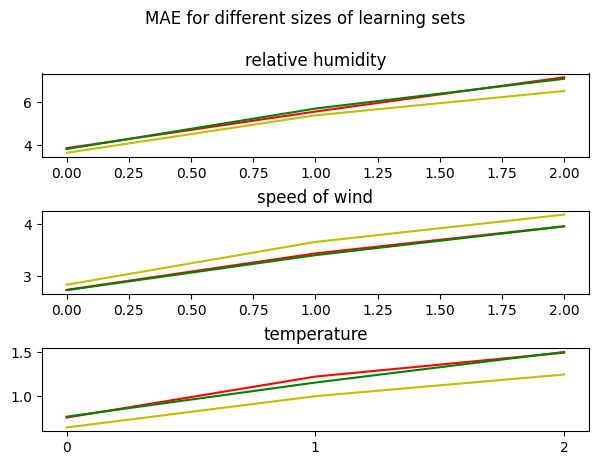

In [10]:
import matplotlib.ticker as mticker

fig, axs = plt.subplots(3)
fig.suptitle('MAE for different sizes of learning sets')
fig.tight_layout(pad=1.8)
fig.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

axs[0].plot(AllMAE_humid_6[0],'r')
axs[0].plot(AllMAE_humid_6[1],'g')
axs[0].plot(AllMAE_humid_6[2],'y')
axs[0].set_title('relative humidity')

axs[1].plot(AllMAE_wind_6[0],'r')
axs[1].plot(AllMAE_wind_6[1],'g')
axs[1].plot(AllMAE_wind_6[2],'y')
axs[1].set_title('speed of wind')

axs[2].plot(AllMAE_temp_6[0],'r')
axs[2].plot(AllMAE_temp_6[1],'g')
axs[2].plot(AllMAE_temp_6[2],'y')
axs[2].set_title('temperature')

# axs[3].plot(actual[2][:])
# axs[3].set_title('temperature')